In [1]:
import feather
import scanpy as sc
import numpy as np
import scanpy as sc
import pandas as pd
from anndata import AnnData
import anndata

In [2]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,10

In [3]:
#read in normalized gene expression matrix
straitum_norm_qc_nuclei = feather.read_dataframe("../data/processed/norm_qc_nuclei.feather")

In [4]:
#read in annoation file
straitum_norm_qc_annotation = pd.read_csv("../data/processed/norm_qc_nuclei_annotation.csv",index_col=0)

In [5]:
straitum_norm_qc_annotation.head()

,cell_id,nUMIs,nGenes,doublet_score,region,full_id,precluster,size_factor
X,,,,,,,,
caudate_AAACCCAGTGGACCAA,AAACCCAGTGGACCAA,123667,7963,0.195725,caudate,caudate_AAACCCAGTGGACCAA,7,2.516823
caudate_AAACGAATCTGGGAGA,AAACGAATCTGGGAGA,52628,5692,0.267317,caudate,caudate_AAACGAATCTGGGAGA,2,1.117240
caudate_AAACGAATCTTGGAAC,AAACGAATCTTGGAAC,105720,7612,0.357998,caudate,caudate_AAACGAATCTTGGAAC,7,2.232862
caudate_AAAGAACCAATGGGTG,AAAGAACCAATGGGTG,41859,4740,0.253000,caudate,caudate_AAAGAACCAATGGGTG,23,0.942491
caudate_AAAGAACTCCCGTTGT,AAAGAACTCCCGTTGT,48878,4953,0.102173,caudate,caudate_AAAGAACTCCCGTTGT,2,1.017234


In [6]:
striatum_ann = AnnData(straitum_norm_qc_nuclei)

Transforming to str index.


In [7]:
striatum_ann.obs_names = straitum_norm_qc_annotation ["full_id"].values
striatum_ann.obs["nUMIs"] = straitum_norm_qc_annotation ["nUMIs"].values
striatum_ann.obs["nGenes"] = straitum_norm_qc_annotation ["nGenes"].values

striatum_ann.obs["region"] = pd.Categorical(straitum_norm_qc_annotation ["region"].values,np.unique(straitum_norm_qc_annotation ["region"].values))

striatum_ann.obs["doublet_score"] = straitum_norm_qc_annotation ["doublet_score"].values
striatum_ann.obs["size_factor"] = straitum_norm_qc_annotation ["size_factor"].values

In [8]:
#to get increase clarity in visualizations we are going to limit our analysis to only highly variable genes
sc.pp.highly_variable_genes(striatum_ann, n_top_genes=7500)

In [9]:
#next we perform PCA and build the KNN graph, and run umap embedtting
sc.pp.pca(striatum_ann, use_highly_variable=True)
sc.pp.neighbors(striatum_ann)
sc.tl.umap(striatum_ann)

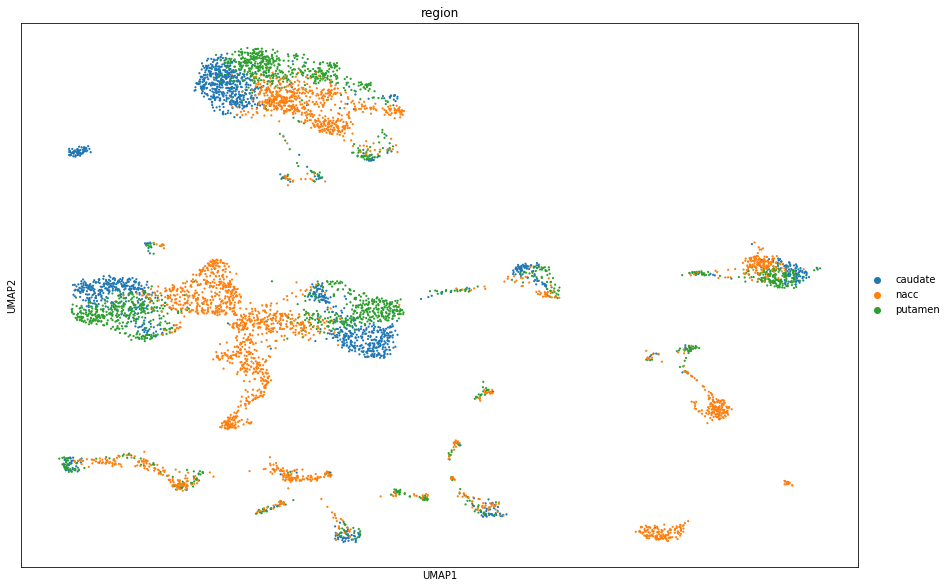

In [10]:

#first lets plot by brainregion
sc.pl.umap(striatum_ann,color="region")

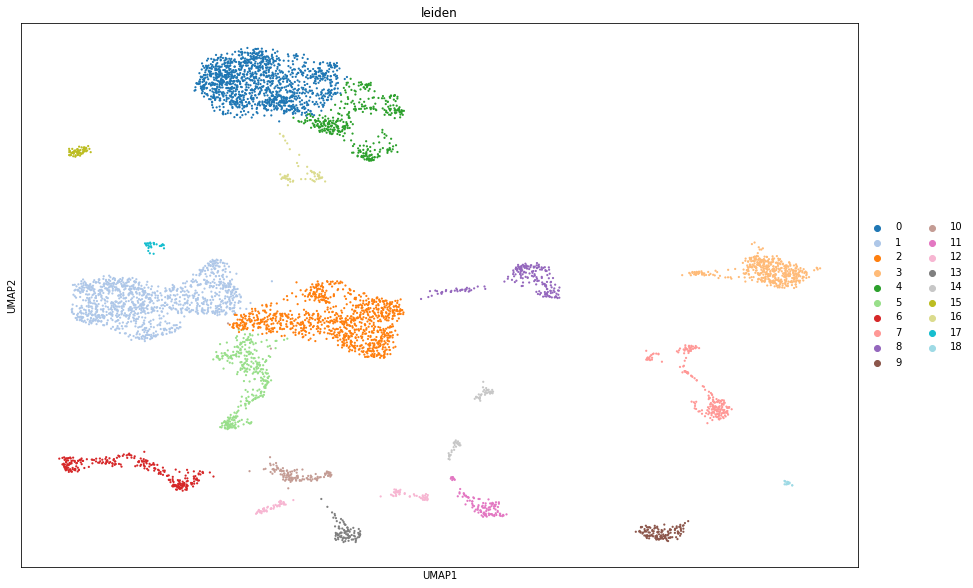

In [11]:
#now we are going to perform leiden clustering on the full population  doi: 10.1016/j.celrep.2016.06.059
sc.tl.leiden(striatum_ann,resolution=0.4)
sc.pl.umap(striatum_ann,color="leiden",palette="tab20")

In [12]:
#we can now load in previous study markers
gocke_et_al_markers = pd.read_csv("../data/raw/gocke_et_al_markers.csv")

In [13]:
gocke_et_al_markers.head()

,Unnamed: 0,gene,spearman.corr,p.value,Cell Type
0,1,Trank1,0.920410,7.970000e-303,Neurons
1,2,Atp1a3,0.918542,2.880000e-299,Neurons
2,3,Ptpn5,0.916477,1.970000e-295,Neurons
3,4,Myt1l,0.914329,1.510000e-291,Neurons
4,5,Scn2b,0.914234,2.230000e-291,Neurons


In [14]:
from collections import defaultdict
gocke_marker_dict = defaultdict(set)
for i in range(gocke_et_al_markers.shape[0]):
    cell_type =gocke_et_al_markers["Cell Type "].values[i]
    gene = gocke_et_al_markers["gene"].values[i].upper()
    gocke_marker_dict[cell_type].add(gene)

In [15]:
##we are now going to assign the leiden clusters to cell types using the markers from gocke et a
import sys
sys.path.insert(1, '../src')
from cluster_profile import profile_anndata
gocke_assignments = profile_anndata(striatum_ann,gocke_marker_dict)

------------------------------------------------------------------------------
CLUSTER: 0


,p_value,label,query_match
0,5.645952e-19,Astrocytes,"BMPR1B,SLC1A3,HTRA1,F3,RORB,ACSBG1,EDNRB,SLC1A2,ATP1A2,ATP13A4,FGFR3"


Cluster 0 has been labeled as Astrocytes
------------------------------------------------------------------------------
CLUSTER: 1


,p_value,label,query_match
0,2.094769e-25,Neurons,"PDE10A,CAMK2B,NDRG4,PTPN5,RBFOX1,DLGAP2,RBFOX3,PDE1B,CACNA2D3,CAMK4,MYT1L,GAD2,CELF5,BCL11B"


Cluster 1 has been labeled as Neurons
------------------------------------------------------------------------------
CLUSTER: 10


,p_value,label,query_match
0,0.000397,Neurons,"CELF4,ERC2,TRANK1,SYT1"


Cluster 10 has been labeled as Neurons
------------------------------------------------------------------------------
CLUSTER: 11


,p_value,label,query_match


Cluster 11 has been labeled as None
------------------------------------------------------------------------------
CLUSTER: 12


,p_value,label,query_match
0,0.007514,OPC,"NXPH1,PCDH15,TMEM108"


Cluster 12 has been labeled as OPC
------------------------------------------------------------------------------
CLUSTER: 13


,p_value,label,query_match


Cluster 13 has been labeled as None
------------------------------------------------------------------------------
CLUSTER: 14


,p_value,label,query_match
0,0.019509,Neurons,"RBFOX3,ERC2,GAD1"


Cluster 14 has been labeled as Neurons
------------------------------------------------------------------------------
CLUSTER: 15


,p_value,label,query_match
0,4.892498e-09,Ependy Cilia,"LRRC36,TTC29,HYDIN,ARMC4,SPAG17,VWA3A"


Cluster 15 has been labeled as Ependy Cilia
------------------------------------------------------------------------------
CLUSTER: 16


,p_value,label,query_match
0,3.978537e-08,Microglia,"IKZF1,P2RY12,GPR34,CX3CR1,LAIR1,APBB1IP"


Cluster 16 has been labeled as Microglia
------------------------------------------------------------------------------
CLUSTER: 17


,p_value,label,query_match
0,0.000006,Neurons,"RBFOX1,CPNE5,PDE1B,GAD2,BCL11B"


Cluster 17 has been labeled as Neurons
------------------------------------------------------------------------------
CLUSTER: 18


,p_value,label,query_match


Cluster 18 has been labeled as None
------------------------------------------------------------------------------
CLUSTER: 2


,p_value,label,query_match
0,5.148957e-23,Neurons,"PDE10A,CAMK2B,PTPN5,RBFOX1,DLGAP2,CPNE5,RBFOX3,PDE1B,CACNA2D3,CAMK4,MYT1L,CELF5,BCL11B"


Cluster 2 has been labeled as Neurons
------------------------------------------------------------------------------
CLUSTER: 3


,p_value,label,query_match
0,1.072098e-08,OPC,"TMEM108,XYLT1,SUSD5,PCDH15,C1QL1,NXPH1"


Cluster 3 has been labeled as OPC
------------------------------------------------------------------------------
CLUSTER: 4


,p_value,label,query_match
0,2.889495e-12,Astrocytes,"BMPR1B,SLC1A3,AQP4,GJA1,SLC1A2,ATP1A2,ATP13A4,FGFR3"


Cluster 4 has been labeled as Astrocytes
------------------------------------------------------------------------------
CLUSTER: 5


,p_value,label,query_match
0,2.201017e-18,Neurons,"RBFOX1,NDRG4,SYT1,RASGRP1,RGS9,CELF4,DLGAP2,RBFOX3,CACNA2D3,CELF5,BCL11B"


Cluster 5 has been labeled as Neurons
------------------------------------------------------------------------------
CLUSTER: 6


,p_value,label,query_match
0,7.948359e-08,Neurons,"RBFOX1,SYT1,CELF4,RBFOX3,MYT1L,CELF5"


Cluster 6 has been labeled as Neurons
------------------------------------------------------------------------------
CLUSTER: 7


,p_value,label,query_match
0,0.000122,Vascular,"ITGA1,ARHGAP29,IGFBP7,LAMA4"


Cluster 7 has been labeled as Vascular
------------------------------------------------------------------------------
CLUSTER: 8


,p_value,label,query_match
0,1.118187e-16,Oligo,"OPALIN,ST18,HHIP,PLLP,MOG,PLEKHH1,FA2H,PRR5L,HAPLN2,BCAS1"


Cluster 8 has been labeled as Oligo
------------------------------------------------------------------------------
CLUSTER: 9


,p_value,label,query_match


Cluster 9 has been labeled as None


In [16]:
zhang_et_al_markers = pd.read_csv("../data/raw/zhang_et_al_markers.csv",index_col=0)

In [17]:
zhang_et_al_markers.head()

,sym,exp,hsEns,cortLfc,source
ensid,,,,,
ENSMUSG00000024411,Aqp4,Astrocyte,ENSG00000171885,1.868141,Zhang et al 2014
ENSMUSG00000060961,Slc4a4,Astrocyte,ENSG00000080493,2.292897,Zhang et al 2014
ENSMUSG00000028364,Tnc,Astrocyte,NaN,2.012652,Zhang et al 2014
ENSMUSG00000068748,Ptprz1,Astrocyte,ENSG00000106278,2.147566,Zhang et al 2014
ENSMUSG00000030307,Slc6a11,Astrocyte,ENSG00000132164,2.110613,Zhang et al 2014


In [18]:
zhang_marker_dict = defaultdict(set)
for i in range(zhang_et_al_markers.shape[0]):
    cell_type =zhang_et_al_markers["exp"].values[i]
    gene = zhang_et_al_markers["sym"].values[i].upper()
    zhang_marker_dict[cell_type].add(gene)

In [19]:
zhang_assignments = profile_anndata(striatum_ann,zhang_marker_dict)

------------------------------------------------------------------------------
CLUSTER: 0


,p_value,label,query_match
0,1.173966e-32,Astrocyte,"SLC15A2,EDNRB,HTRA1,DAAM2,SPARCL1,FGFR3,BMPR1B,PAMR1,LRIG1,TNC,ATP1A2,SLC1A3,RGS20,F3,MFGE8,ACSBG1,SLC1A2,SLC25A18,ATP13A4"


Cluster 0 has been labeled as Astrocyte
------------------------------------------------------------------------------
CLUSTER: 1


,p_value,label,query_match


Cluster 1 has been labeled as None
------------------------------------------------------------------------------
CLUSTER: 10


,p_value,label,query_match
0,0.004798,Neuron,"CELF4,ELAVL2,SYT1,CACNA2D2"


Cluster 10 has been labeled as Neuron
------------------------------------------------------------------------------
CLUSTER: 11


,p_value,label,query_match
0,0.000004,Neuron,"CNTNAP2,ELAVL2,SYNPR,GAD1,GRIA1,LHX6"


Cluster 11 has been labeled as Neuron
------------------------------------------------------------------------------
CLUSTER: 12


,p_value,label,query_match
0,2.018131e-09,Neuron,"CNTNAP2,NOS1,SST,ELAVL2,SYNPR,SYN2,BCL11A,LHX6"
1,7.684216e-02,OligoDendPrec,"NXPH1,PCDH15"


Cluster 12 has been labeled as Neuron
------------------------------------------------------------------------------
CLUSTER: 13


,p_value,label,query_match
0,0.000796,OligoDendPrec,"SMOC1,NXPH1,XYLT1"


Cluster 13 has been labeled as OligoDendPrec
------------------------------------------------------------------------------
CLUSTER: 14


,p_value,label,query_match
0,0.004798,Neuron,"SYN2,GNG2,GAD1,CNTNAP2"


Cluster 14 has been labeled as Neuron
------------------------------------------------------------------------------
CLUSTER: 15


,p_value,label,query_match


Cluster 15 has been labeled as None
------------------------------------------------------------------------------
CLUSTER: 16


,p_value,label,query_match
0,2.926964e-34,Microglia,"PLCG2,VAV1,HCK,PIK3R5,DOCK2,APBB1IP,LYN,ENTPD1,IKZF1,LCP2,MYO1F,PLCB2,P2RY12,GPR34,TGFB1,LAIR1,RCSD1,INPP5D,PIK3AP1,SLCO2B1,RGS10,CX3CR1,DOCK8,FGD2,CSF1R,TBXAS1"


Cluster 16 has been labeled as Microglia
------------------------------------------------------------------------------
CLUSTER: 17


,p_value,label,query_match
0,0.004798,Neuron,"MEG3,BCL11A,THSD7B,CACNA2D2"


Cluster 17 has been labeled as Neuron
------------------------------------------------------------------------------
CLUSTER: 18


,p_value,label,query_match
0,0.007299,Endothelial,"RBPMS,FN1,AKAP12,FZD6,UACA"


Cluster 18 has been labeled as Endothelial
------------------------------------------------------------------------------
CLUSTER: 2


,p_value,label,query_match
0,0.000004,Neuron,"ROBO2,CNR1,RELN,CACNA2D3,NSG2,CELF5"


Cluster 2 has been labeled as Neuron
------------------------------------------------------------------------------
CLUSTER: 3


,p_value,label,query_match
0,1.285019e-10,OligoDendPrec,"MYT1,XYLT1,NXPH1,PCDH15,SMOC1,DPP6"
1,4.396303e-03,OligoDendAll,"SULF2,SEMA5A,BCAS1"


Cluster 3 has been labeled as OligoDendPrec
------------------------------------------------------------------------------
CLUSTER: 4


,p_value,label,query_match
0,2.169188e-30,Astrocyte,"SLC15A2,BMPR1B,PAMR1,LRIG1,SLC1A3,GFAP,DAAM2,TNC,SPARCL1,AQP4,GJA1,ID4,SLC1A2,SLC25A18,ATP1A2,PTPRZ1,ATP13A4,FGFR3"


Cluster 4 has been labeled as Astrocyte
------------------------------------------------------------------------------
CLUSTER: 5


,p_value,label,query_match
0,1.021066e-07,Neuron,"NDRG4,SYT1,CELF4,SYN2,CACNA2D3,CELF5,GRIA1"


Cluster 5 has been labeled as Neuron
------------------------------------------------------------------------------
CLUSTER: 6


,p_value,label,query_match
0,0.000161,Neuron,"SYT1,CELF4,SYNPR,SYN2,CELF5"


Cluster 6 has been labeled as Neuron
------------------------------------------------------------------------------
CLUSTER: 7


,p_value,label,query_match
0,7.417870e-02,Astrocyte,"ATP1A2,FAM20A,SLC7A11"
1,4.632131e-11,Endothelial,"ITGA1,RBPMS,MYO1B,CGNL1,IGFBP7,SLC22A8,ARHGAP29,LAMA4,NID1,FZD6,UACA"


Cluster 7 has been labeled as Endothelial
------------------------------------------------------------------------------
CLUSTER: 8


,p_value,label,query_match
0,5.136279e-09,OligoDendAll,"SLC44A1,ENPP2,SH3GL3,FA2H,PLLP,BCAS1"


Cluster 8 has been labeled as OligoDendAll
------------------------------------------------------------------------------
CLUSTER: 9


,p_value,label,query_match
0,0.097335,Endothelial,"RBPMS,ANXA2,UACA,FN1"


Cluster 9 has been labeled as Endothelial


In [20]:
pd.DataFrame({"gocke":pd.Series(gocke_assignments),"zhang":pd.Series(zhang_assignments)})

,gocke,zhang
0,Astrocytes,Astrocyte
1,Neurons,None
10,Neurons,Neuron
11,None,Neuron
12,OPC,Neuron
13,None,OligoDendPrec
14,Neurons,Neuron
15,Ependy Cilia,None
16,Microglia,Microglia
17,Neurons,Neuron


In [21]:
#cluster 6 and 12 had discrepency so we are going to look at the top marker genes on DropViz http://dropviz.org/
is_mark = [ctype == "7" for ctype in striatum_ann.obs["leiden"].values]
striatum_ann.obs["mark"] = pd.Categorical(
            values=is_mark,
            categories=[True, False])
sc.tl.rank_genes_groups(striatum_ann, "mark")
gene_list = [tup[0] for tup in striatum_ann.uns["rank_genes_groups"]["names"]]
print("Cluster 7 Marker genes")
print(gene_list[:20])


is_mark = [ctype == "9" for ctype in striatum_ann.obs["leiden"].values]
striatum_ann.obs["mark"] = pd.Categorical(
            values=is_mark,
            categories=[True, False])
sc.tl.rank_genes_groups(striatum_ann, "mark")
gene_list = [tup[0] for tup in striatum_ann.uns["rank_genes_groups"]["names"]]
print("Cluster 9 Marker genes")
print(gene_list[:20])


is_mark = [ctype == "12" for ctype in striatum_ann.obs["leiden"].values]
striatum_ann.obs["mark"] = pd.Categorical(
            values=is_mark,
            categories=[True, False])
sc.tl.rank_genes_groups(striatum_ann, "mark")
gene_list = [tup[0] for tup in striatum_ann.uns["rank_genes_groups"]["names"]]
print("Cluster 12 Marker Genes")
print(gene_list[:20])



is_mark = [ctype == "13" for ctype in striatum_ann.obs["leiden"].values]
striatum_ann.obs["mark"] = pd.Categorical(
            values=is_mark,
            categories=[True, False])
sc.tl.rank_genes_groups(striatum_ann, "mark")
gene_list = [tup[0] for tup in striatum_ann.uns["rank_genes_groups"]["names"]]
print("Cluster 13 Marker Genes")
print(gene_list[:20])

#cluster 7 marker genes appear in endothelial cells in the mouse striatum
#cluster 9 marker genes appear in fibroblast like mural cells in the mouse striatum

#cluster 12 marker genes appear in interneurons in the mouse striatum
#cluster 13 marker genes appear in interneurons in the mouse striatum


Cluster 7 Marker genes
['ITIH5', 'SVIL', 'UACA', 'COLEC12', 'LAMA2', 'PHLDB2', 'CFH', 'BMP6', 'KCNT2', 'PPFIBP1', 'NR2F2-AS1', 'SLC6A12', 'SLC16A12', 'ADAMTS9-AS2', 'LHFPL6', 'SLC6A13', 'KANK2', 'TGFBR3', 'SLC6A20', 'CEMIP']
Cluster 9 Marker genes
['SLC47A1', 'THSD4', 'BNC2', 'AC025627.1', 'TBX15', 'ABCC4', 'EYA1', 'ADAMTSL1', 'SLC38A2', 'ARHGEF28', 'ESR2', 'ITGBL1', 'EBF1', 'TGFBR3', 'SPTLC3', 'NPNT', 'FMO3', 'SLC26A2', 'C22orf34', 'ADAM12']
Cluster 12 Marker Genes
['LHX6', 'KCNC2', 'NXPH1', 'LRP8', 'ELAVL2', 'ANK1', 'GABBR2', 'MAST1', 'AL445623.2', 'RAB3C', 'RPS6KA2', 'GALNT14', 'IGF1', 'XKR4', 'SCN9A', 'SPRY4-AS1', 'BAIAP3', 'NHS', 'TOX2', 'AFF2']
Cluster 13 Marker Genes
['SPOCK1', 'CDH22', 'LHX6', 'SDK2', 'AC023282.1', 'NXPH2', 'PLPP4', 'EML6', 'TRHDE', 'ST8SIA2', 'CHRNA7', 'TRPC5', 'ZNF536', 'ALK', 'GABBR2', 'ARHGAP28', 'LRFN2', 'GRIA4', 'PDE1C', 'PCSK5']


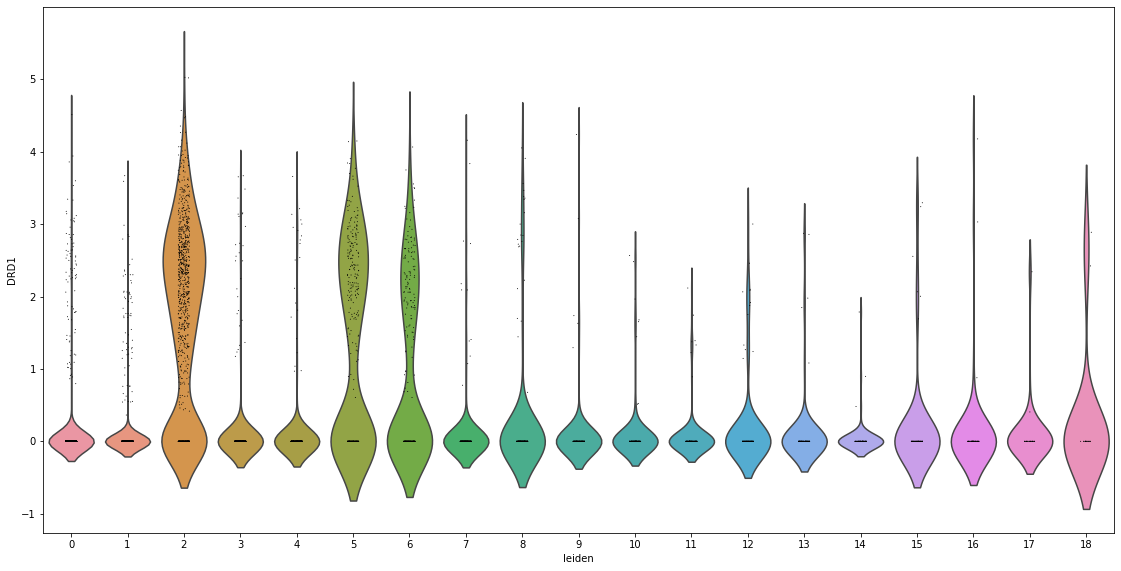

In [22]:
#we can further assign the neuronal markers to MSNs based on DRD1 and DRD2 expression 
sc.pl.violin(striatum_ann,keys=["DRD1"],groupby="leiden")

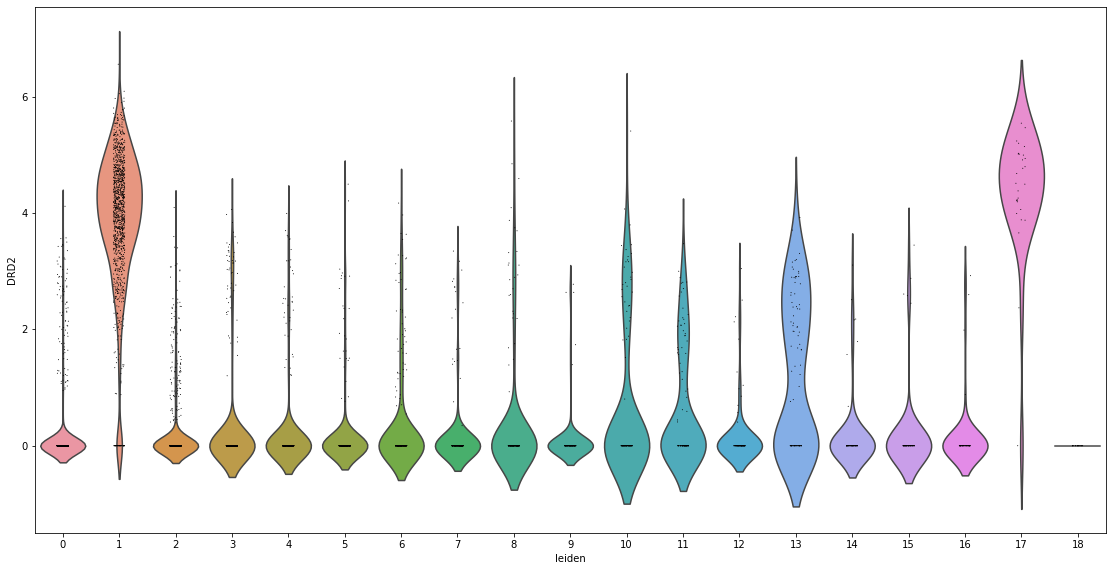

In [23]:
sc.pl.violin(striatum_ann,keys=["DRD2"],groupby="leiden")

In [24]:
#we will assign the rest of the neurons to the inteneruons
final_cluster_assignment = {'0': 'Astrocyte',
 '1': 'D2 Neuron',
 '10': 'Interneuron',
 '11': 'Interneuron',
 '12': 'Interneuron',
 '13': 'Interneuron',
 '14': 'Interneuron',
 '15': 'Epyndymal Cell',
 '16': 'Microglia',
 '17': 'D2 Neuron',
 '18': 'Endothelial Cell',
 '2': 'D1 Neuron',
 '3': 'OligoDendPrec',
 '4': 'Astrocyte',
 '5': 'D1 Neuron',
 '6': 'D1 Neuron',
 '7': 'Endothelial Cell',
 '8': 'Oligodendrocyte',
 '9': 'Mural Cell'}
nuclei_cell_type_assignments = np.asarray([final_cluster_assignment[clust] 
                                           for clust in striatum_ann.obs["leiden"].values])
cell_type_order= ["D1 Neuron","D2 Neuron","Interneuron",'Astrocyte','Microglia','Oligodendrocyte',
                  "OligoDendPrec","Endothelial Cell","Mural Cell","Epyndymal Cell"]
striatum_ann.obs["cell_type"] = pd.Categorical(nuclei_cell_type_assignments,cell_type_order)

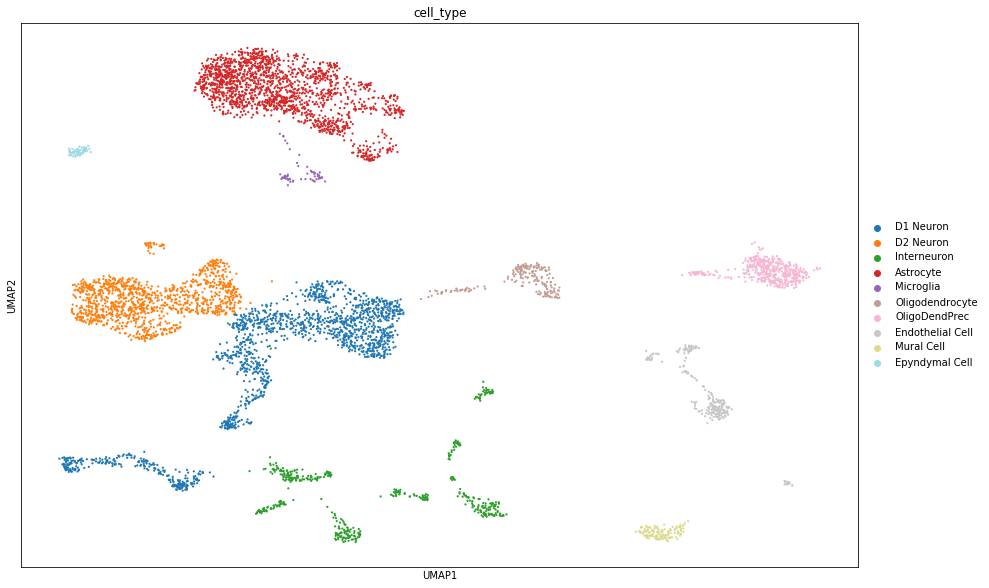

In [25]:
sc.pl.umap(striatum_ann,color="cell_type",palette="tab20")

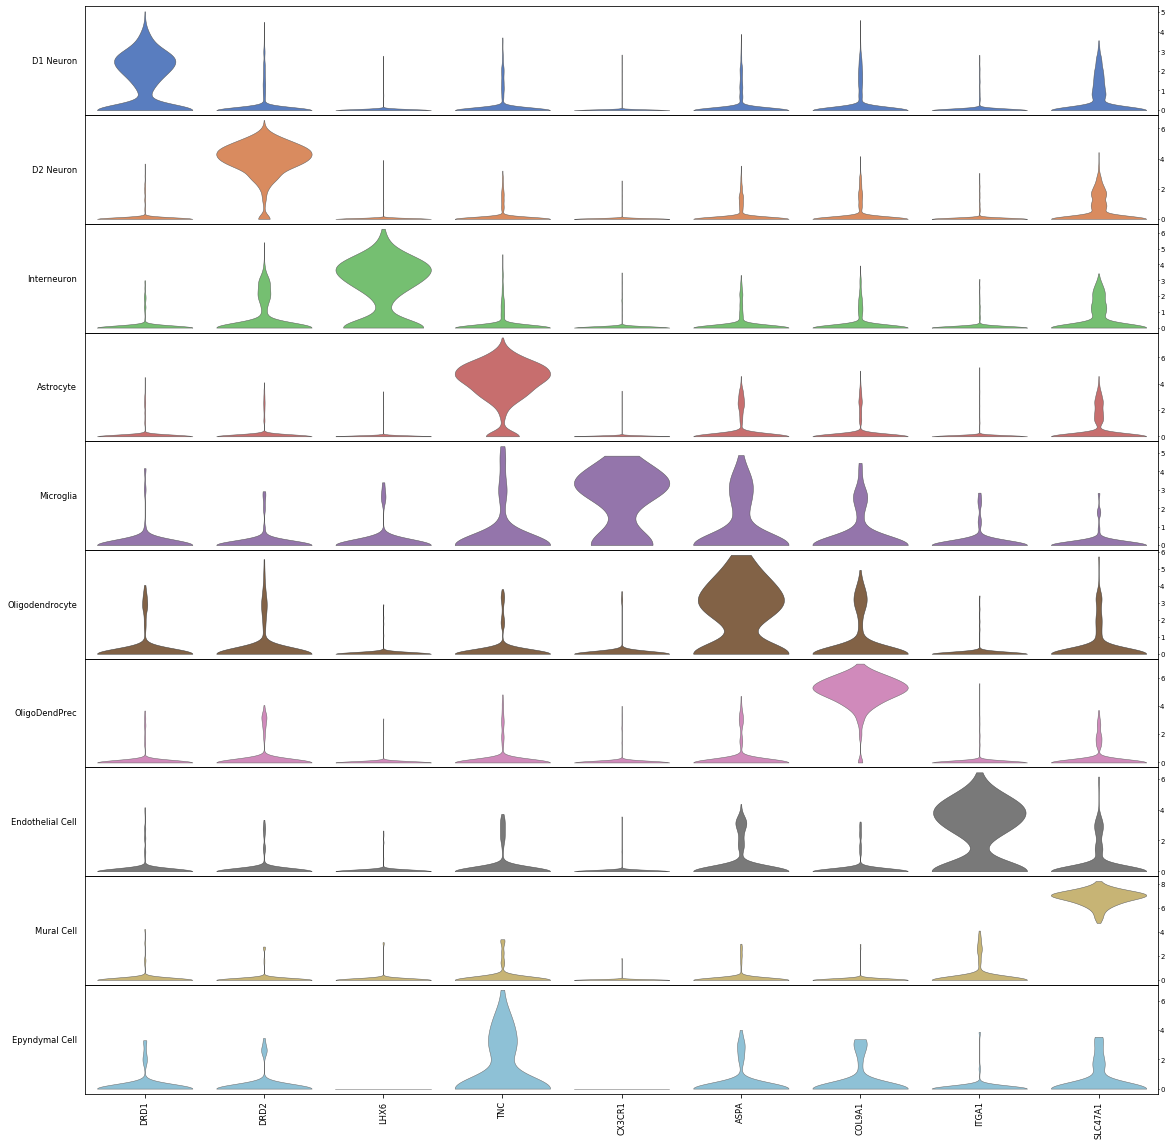

In [26]:
#we can check our clustring with both a stacked violin plot and hexplots
sc.pl.stacked_violin(striatum_ann,var_names=["DRD1","DRD2","LHX6","TNC","CX3CR1","ASPA",
                                             "COL9A1","ITGA1","SLC47A1"],groupby="cell_type",figsize=(20,20))

In [27]:
["DRD1","DRD2","LHX6","TNC","CX3CR1","ASPA","COL9A1","ITGA1","SLC47A1"]

['DRD1', 'DRD2', 'LHX6', 'TNC', 'CX3CR1', 'ASPA', 'COL9A1', 'ITGA1', 'SLC47A1']

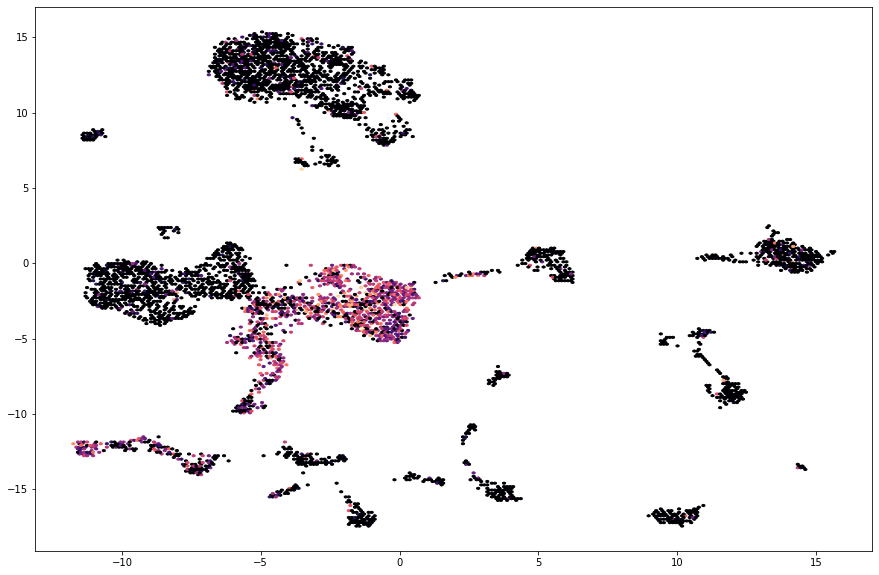

In [28]:
#D1 cell type marker 
plt.hexbin(x=striatum_ann.obsm["X_umap"][:,0],y=striatum_ann.obsm["X_umap"][:,1],C=striatum_ann.obs_vector("DRD1"),gridsize=250,cmap="magma")


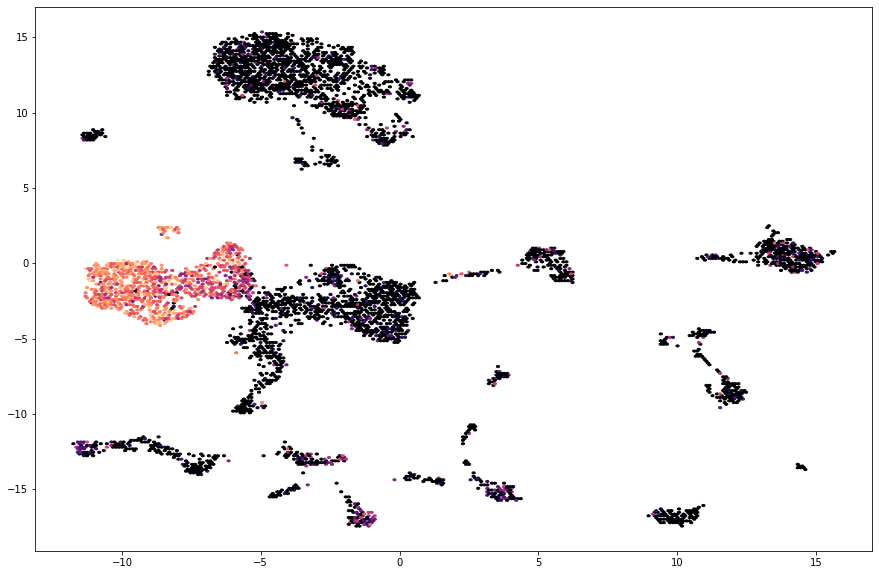

In [29]:
#D2 cell type marker
plt.hexbin(x=striatum_ann.obsm["X_umap"][:,0],y=striatum_ann.obsm["X_umap"][:,1],C=striatum_ann.obs_vector("DRD2"),gridsize=250,cmap="magma")


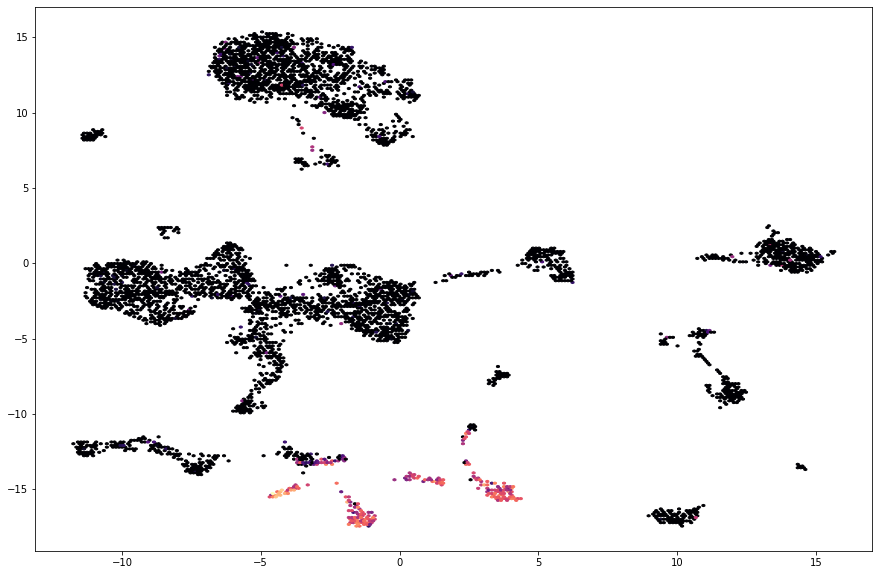

In [30]:
#Interneuron marker
plt.hexbin(x=striatum_ann.obsm["X_umap"][:,0],y=striatum_ann.obsm["X_umap"][:,1],C=striatum_ann.obs_vector("LHX6"),gridsize=250,cmap="magma")


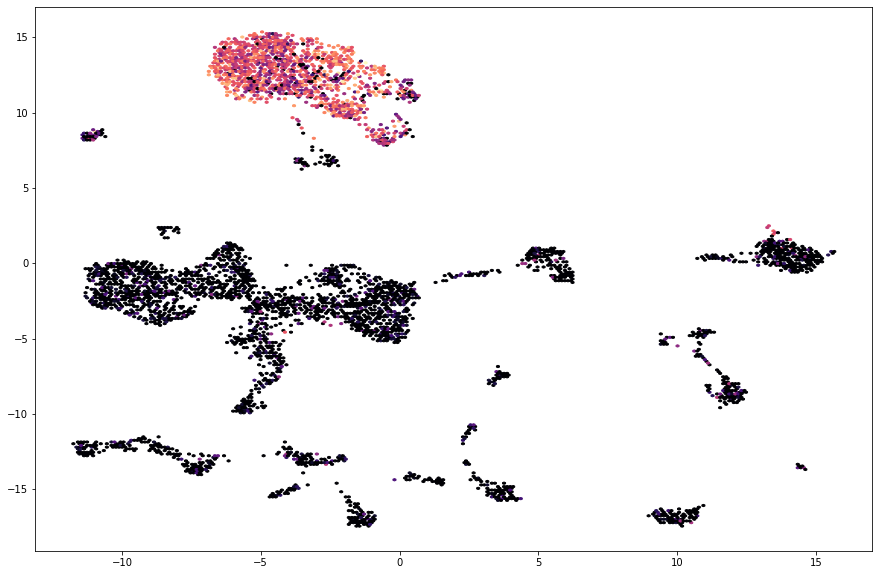

In [31]:
#Astrocyte marker
plt.hexbin(x=striatum_ann.obsm["X_umap"][:,0],y=striatum_ann.obsm["X_umap"][:,1],C=striatum_ann.obs_vector("TNC"),gridsize=250,cmap="magma")


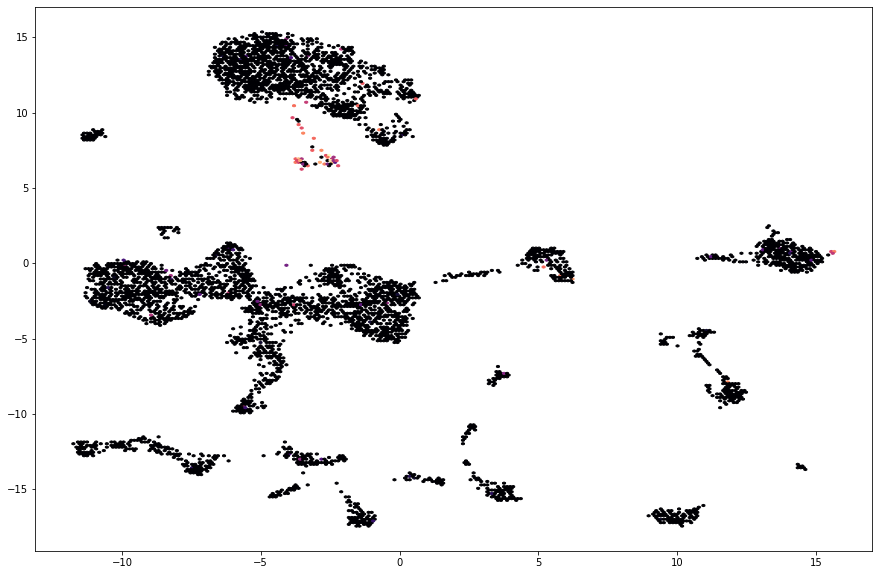

In [32]:
#Microglia marker
plt.hexbin(x=striatum_ann.obsm["X_umap"][:,0],y=striatum_ann.obsm["X_umap"][:,1],C=striatum_ann.obs_vector("CX3CR1"),gridsize=250,cmap="magma")


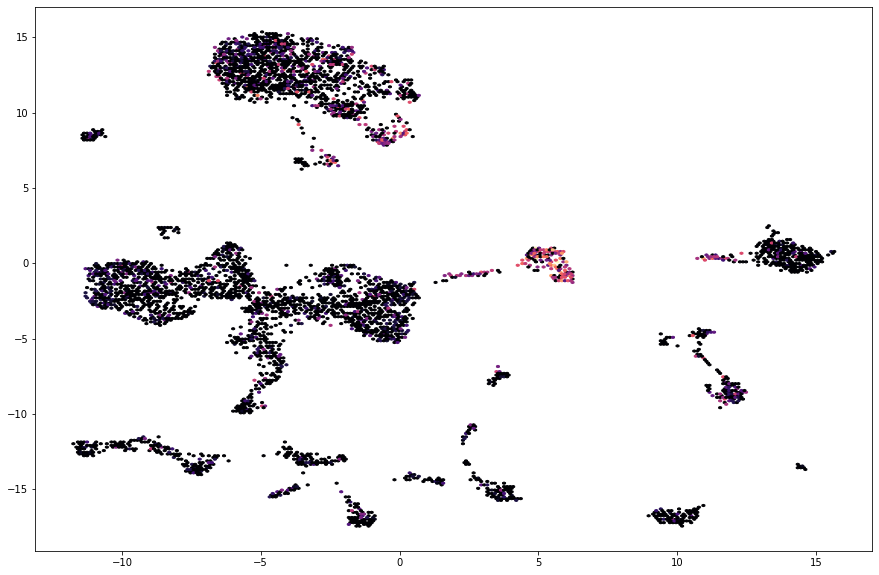

In [33]:
#Oligodendrocyte marker
plt.hexbin(x=striatum_ann.obsm["X_umap"][:,0],y=striatum_ann.obsm["X_umap"][:,1],C=striatum_ann.obs_vector("ASPA"),gridsize=250,cmap="magma")


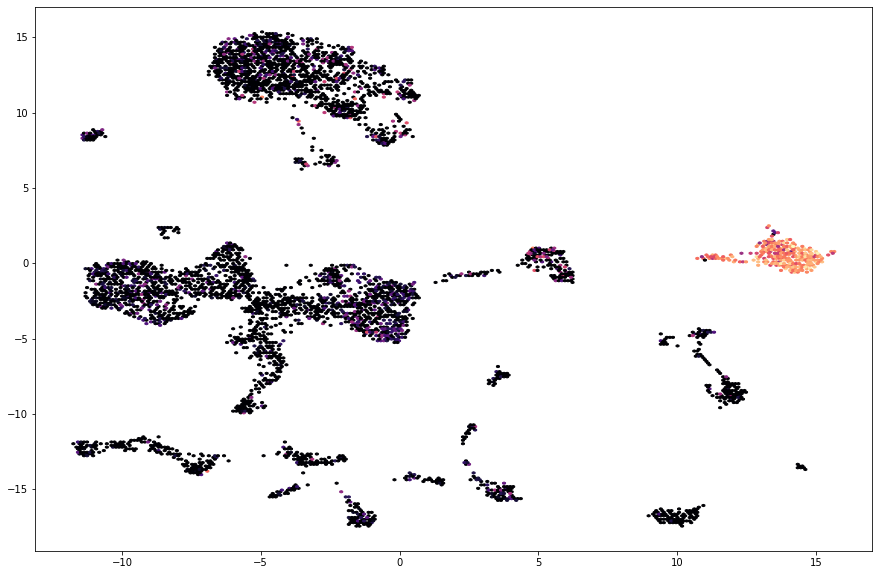

In [34]:
#Oligodendrocyte percursor marker
plt.hexbin(x=striatum_ann.obsm["X_umap"][:,0],y=striatum_ann.obsm["X_umap"][:,1],C=striatum_ann.obs_vector("COL9A1"),gridsize=250,cmap="magma")


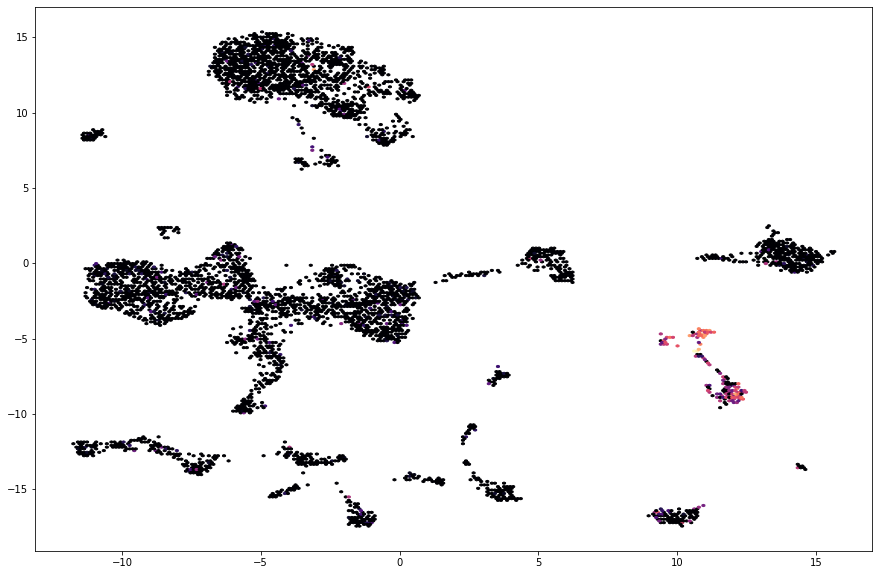

In [35]:
#Endothelial cell marker
plt.hexbin(x=striatum_ann.obsm["X_umap"][:,0],y=striatum_ann.obsm["X_umap"][:,1],C=striatum_ann.obs_vector("ITGA1"),gridsize=250,cmap="magma")


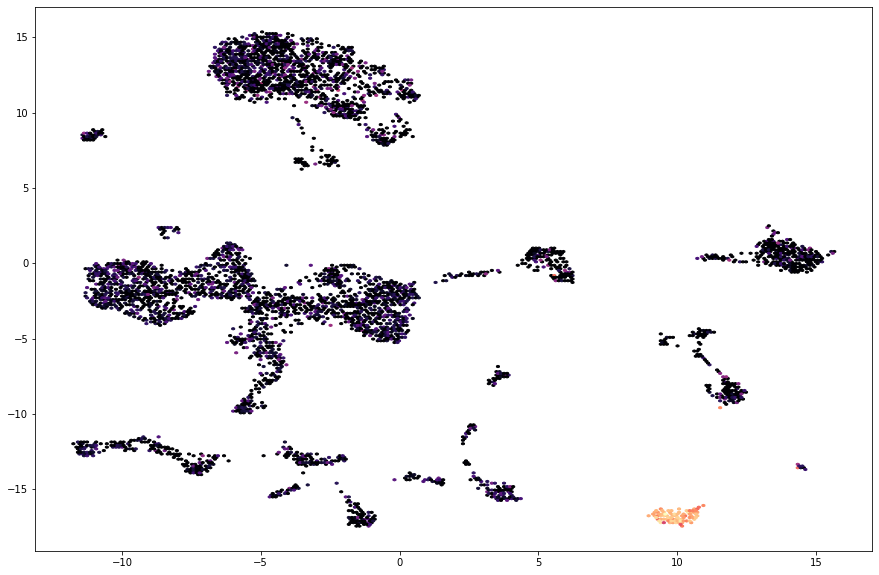

In [36]:
#Mural cell marker
plt.hexbin(x=striatum_ann.obsm["X_umap"][:,0],y=striatum_ann.obsm["X_umap"][:,1],C=striatum_ann.obs_vector("SLC47A1"),gridsize=250,cmap="magma")


In [37]:
#we will export the medium spiny neurons D1/D2 for further analysis
msn_idx = [ctype in ["D1 Neuron","D2 Neuron"] for ctype in striatum_ann.obs["cell_type"].values]
msn_annot = straitum_norm_qc_annotation.loc[msn_idx,:]
msn_nuclei =  straitum_norm_qc_nuclei.loc[msn_idx,:]

In [38]:
#write msn files
feather.write_dataframe(msn_nuclei,"../data/processed/msn_nuclei.feather")
msn_annot.to_csv("../data/processed/msn_nuclei_annotation.csv")

In [83]:
#now we want to make a heatmap of our relevant cell types
relevant_cell_types = ["D1 Neuron","D2 Neuron","Interneuron",'Astrocyte','Microglia','Oligodendrocyte',
                       "OligoDendPrec","Endothelial Cell","Mural Cell"]
heatmap_cells = []
for cell_type in relevant_cell_types:
    selected_idx = nuclei_cell_type_assignments==cell_type
    selected_rows = np.asarray(list(range(straitum_norm_qc_nuclei.shape[0])))[selected_idx]
    heatmap_cells.extend(np.random.choice(selected_rows,50,replace=False).tolist())
    

In [84]:
#we will select the marker genes for the heatmap with a simple t-test
heatmap_marker_genes = []
for cell_type in relevant_cell_types:
    is_mark = [ctype == cell_type for ctype in striatum_ann.obs["cell_type"].values]
    striatum_ann.obs["mark"] = pd.Categorical(
        values=is_mark,
        categories=[True, False])
    sc.tl.rank_genes_groups(striatum_ann, "mark",method="t-test")
    m_genes = [tup[0] for tup in striatum_ann.uns["rank_genes_groups"]["names"]]
    heatmap_marker_genes.extend(m_genes[:50])

In [85]:
#to improve the heatmap visualization we rescale each gene
from sklearn.preprocessing import maxabs_scale
heatmap_values = straitum_norm_qc_nuclei[heatmap_marker_genes].iloc[heatmap_cells,:].values
scaled_heatmap_values = maxabs_scale(heatmap_values)

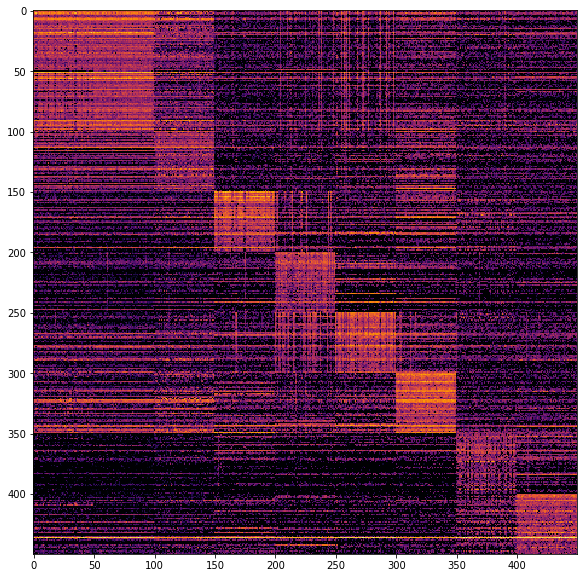

In [86]:
plt.imshow(heatmap_values.transpose(),cmap="inferno",vmin=0.45)